In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "-1"

In [16]:
import sys
import tensorflow as tf
import tensorflow.keras as keras
print('python version:', sys.version)
print('tensorflow version:', tf.__version__)
print("keras {}".format(keras.__version__))

# cifar10
from tensorflow.keras import datasets, layers, models

import matplotlib.pyplot as plt
import numpy as np
import random


python version: 3.10.4 | packaged by conda-forge | (main, Mar 30 2022, 08:38:02) [MSC v.1916 64 bit (AMD64)]
tensorflow version: 2.9.1
keras 2.9.0


In [3]:
# loading the dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

train_images, test_images = train_images / 255.0, test_images / 255.0

label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
               'horse', 'ship', 'truck']

In [4]:
model = tf.keras.models.load_model('../../../build/saved_model/Simple_CNN/HDF5/Simple_CN.h5', compile=True)

In [5]:
test_image = train_images[0]
test_label = train_labels[0]
target_label = random.randint(0, 9)

print(f'test_label: {test_label[0]}, target_label: {target_label}')


test_label: 6, target_label: 9


In [6]:
test_label = tf.one_hot(test_label, 10)[0]
target_label = tf.one_hot(target_label, 10)

In [7]:
def calculate_grad(image, label):
    ''' calculate the gradient of the image 
    args:
        image(numpy.ndarray): the image to be attacked, shape: [32, 32, 3]
        label(one hot tensor): the label of the image, shape: [10, ]

    example:
        jacobian = calculate_jacobian(test_image, test_label)

    return:
        jacobian(numpy.ndarray): the jacobian matrix, shape: [32, 32, 3]

    '''


    image = tf.cast(image, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(image)
        logits = model(tf.reshape(image, [1, 32, 32, 3]))[0]
        loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=label)
    grad = tape.gradient(loss, image)

    return grad


In [8]:
grad = calculate_grad(test_image, test_label)

In [9]:
##实现saliency_map
def saliency_map(derivative, mask):
    ## derivative 前导矩阵，mask初始为全1,且与img大小一样
    alphas = derivative * mask
    ## pixel influence on sum of residual classes
    betas = -np.ones_like(alphas)
    ## 下面一步过滤了全0
    sal_map = np.abs(alphas) * np.abs(betas) * np.sign(alphas * betas)
    ## 找到最小元素的位置
    ## 算出α参数，这里简化了β参数的计算，相当于只关注了α参数。
    idx = np.argmin(sal_map)
    ##转换成(p1,p2)格式
    idx = np.unravel_index(idx, mask.shape)
    pix_sign = np.sign(alphas)[idx]
    
    return idx, pix_sign

In [10]:
mask = np.ones_like(test_image)

In [11]:
saliency_map(grad, mask)

((20, 16, 0), 1.0)

In [12]:
def JSMA(input_image,target_label,epochs=100,theta=.1,max_=1,min_=0):
    '''
    :param input_image: input image 32*32 RGB
    :param target_label: 0...9
    :param epochs: Maximum number of iterations
    :param theta: Perturbation factor, in the paper is 1
    :param max_: Maximum pixel boundary
    :param min_: Minimum pixel boundary
    :return: adv_image 32*32*3
    '''

    mask = np.ones_like(input_image)
    for epoch in range(epochs):
        input_image = tf.cast(input_image,tf.float32)

        s = model(tf.reshape(input_image, [1, 32, 32, 3]))[0]

        derivative = calculate_grad(input_image,target_label)
        
        predictions = np.squeeze(s)
        input_image = input_image.numpy()
        top_k = predictions.argsort()[-3:][::-1]
        predictions_id=top_k[0]
        ## print("epoch={} label={}".format(epoch,predictions_id))
        if predictions_id == np.where(target_label == 1)[0][0]:
        ## for node_id in top_k:
        ## print('(score = %.5f)(id = %d)' % (predictions[node_id],predictions_id))
            break
        idx,pix_sign = saliency_map(derivative,mask)
        ## apply perturbation
        input_image[idx]+=pix_sign * theta * (max_ - min_)
        ##Points that have reached their limit are no longer involved in the update
        if (input_image[idx]<=min_) or (input_image[idx]>=max_):
        ## print("idx={} over {}".format(idx,input_image[idx]))
            mask[idx]=0
            input_image[idx]=np.clip(input_image[idx], min_, max_)
    
    
    return input_image

In [ ]:
model_list = ['../../../build/saved_model/Simple_CNN/HDF5/Simple_CN.h5',
    '../../../build/saved_model/VGG19_TransferLearning/HDF5/VGG19_TransferLearning.h5',
    '../../../build/saved_model/ResNet_TransferLearning/HDF5/ResNet_TransferLearning.h5',
    '../../../build/saved_model/DenseNet121_TransferLearning/HDF5/DenseNet121_TransferLearning.h5',
    '../../../build/saved_model/ResNet_V2_TransferLearning/ResNet_V2.h5']

In [ ]:
model_name_list = ['Simple_CN', 'VGG19', 'ResNet', 'DenseNet121', 'ResNet_V2']

In [ ]:
for i in range(len(model_list)):
    acc_before = 0
    acc_after = 0
    range_num = 10000

    model = tf.keras.models.load_model(model_list[i], compile=True)

    for j in range(range_num):
        test_image = train_images[j]
        test_label = train_labels[j]
        target_label = random.randint(0, 9)

        while target_label == test_label[0]:
            target_label = random.randint(0, 9)
        
        test_label = tf.one_hot(test_label, 10)[0]
        target_label = tf.one_hot(target_label, 10)

        tmp = JSMA(test_image,target_label)

        if model(tf.reshape(test_image, [1, 32, 32, 3]))[0].numpy().argmax() != test_label[0]:
            acc_before += 1

        if model(tmp.reshape(1, 32, 32, 3))[0].numpy().argmax() != test_label[0]:
            acc_after += 1
            #print(f'{count} image is JSMA attack success')

    print(f'Acc of {model_name_list[i]} before attack : {acc_before / range_num}')
    print(f'Acc of {model_name_list[i]} after attack : {acc_after / range_num}')
    

In [49]:
ran_num = random.randint(0, 10000)
test_image = train_images[ran_num]
test_label = train_labels[ran_num]
target_label = random.randint(0, 9)

while target_label == test_label[0]:
    target_label = random.randint(0, 9)

test_label = tf.one_hot(test_label, 10)[0]
target_label = tf.one_hot(target_label, 10)

image_adv = JSMA(test_image,target_label)

disturbance = image_adv - test_image

Text(0.5, 1.0, 'Disturbance')

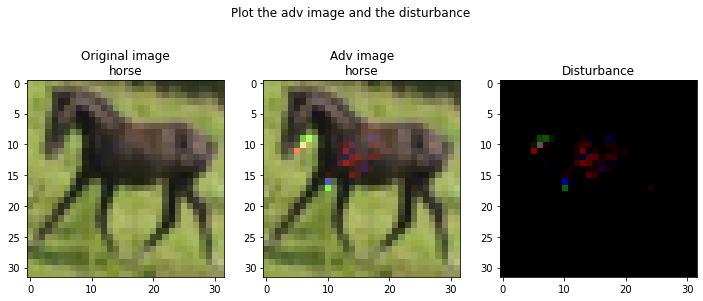

In [50]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle('Plot the adv image and the disturbance')
ax1.imshow(test_image)
ax1.set_title(f'Original image\n{label_names[tf.get_static_value(tf.argmax(model(tf.reshape(test_image, [1, 32, 32, 3]))[0]))]}')
ax2.imshow(image_adv.reshape(32, 32, 3))
ax2.set_title(f'Adv image\n{label_names[tf.get_static_value(tf.argmax(model(tf.reshape(image_adv, [1, 32, 32, 3]))[0]))]}')
ax3.imshow( tf.clip_by_value(disturbance, 0, 1))
ax3.set_title('Disturbance')